In [ ]:
# This file was copied to the AlohaCollisionDetector file and modified

In [ ]:
!pip install PyWavelets

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json
from google.colab import drive
drive.mount('/content/drive')
%ls

Mounted at /content/drive
drive/  sample_data/


In [ ]:
# Read the uploaded files
with open('inphase_quadrature_data.json') as f:
  data = np.array(json.load(f))
with open('inphase_quadrature_noise.json') as f:
  noise = np.array(json.load(f))

In [ ]:
# Signal processing
import pywt # Discrete wavelet transform
from scipy.ndimage import gaussian_filter1d
import scipy.signal as signal

# Classification
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
# Convert in-phase and quadrature signals to the complex-valued
iqdata = data[:,0,:] + 1j*data[:,1,:]
iqnoise = noise[:,0,:] + 1j*noise[:,1,:]

np.save('iq_data.npy', iqdata)
np.save('iq_noise.npy', iqnoise)

In [ ]:
# Singular Spectrum Analysis
#---
def vec2hankel(vec, ncols):
  hankel = np.empty((len(vec)-ncols+1, ncols), dtype=complex)
  for i in range(len(hankel)):
    hankel[i] = vec[i:i+ncols]
  return hankel
#---
def hankel2vec(hankel):
  nrows, ncols = hankel.shape
  vec = np.zeros((nrows+ncols-1), dtype=complex)
  # first upper triangle of the hankel matrix
  for i in range(ncols):
    vec[i] = np.trace(np.flip(hankel[0:0+ncols,:], axis=0), offset= -ncols+1+i )/(i+1)
    #print(i, vec[i])
  # the body of the matrix
  for i in range(ncols+1,nrows):
    vec[i-1] = np.trace(np.flip(hankel[i-ncols:i,:], axis=0))/ncols
    #print(i, vec[i])
  # the rest of the matrix
  for i in range(nrows,nrows+ncols):
    vec[i-1] = np.trace(np.flip(hankel[nrows-ncols:nrows,:], axis=0), offset= -nrows+i )/(ncols+nrows-i)
    #print(nrows-ncols,nrows, -nrows+i, ncols+nrows-i)
    #print(hankel[nrows-ncols:nrows,:])
    #print(i, vec[i])
  return vec
#---
def ssa(vec, ncols, ncomps):
  h  = vec2hankel(vec,ncols)
  u, s, vt = np.linalg.svd(h)
  # Reconstruct the first ncomps SVD sigular values
  h1 = u[:,0:ncomps] @ np.diag(s[0:ncomps]) @ vt[0:ncomps,:]
  hr = u[:,0:ncomps] @ np.diag(s[0:ncomps]) # @ vt[0:ncomps,:] # Suppress rotation
  # Reconstruct the sourse vector of the same length
  x1 = hankel2vec(h1)
  # Return both the hankel matrix and the vector
  # Return results of analysis
  lambd = s[0:ncomps]         # NEW
  rotat =  vt[0:ncomps,:]     # NEW
  # rotat = rotat.reshape(-1)   # NEW
  return x1, h1, hr, lambd, rotat

In [ ]:
# Extract energy of each time series
energy = np.sum(np.abs(iqdata+iqnoise)**2, axis=1)
# Plot the empirical distribution of the signal energy
# plt.hist(energy, bins=20)
# plt.xlabel('Energy') #, c*v^2*s^2')
# plt.ylabel('Frequency')
# plt.show()

In [ ]:
# Prepare a doulbe two-class classification dataset: one versus two transmitters
# Assume that the signal amplitude attenuates proportionally to the distance to the reader and set
# FIX the harcode; put the formula with phase shift here
attenuation = np.array([.8, .8])
indices = np.random.choice(len(data), len(data), replace=False) # Randomly select '(for double see the second argument)' indices from the sample set
iqdata2 = iqdata[indices]
indices = np.random.choice(len(data), len(data), replace=False) # Same, decouple the noise idices
iqnoise2 = iqnoise[indices]
# Blend the original data noise, too
indices = np.random.choice(len(data), len(data), replace=False)
iqnoise = iqnoise[indices]
# Gather all four matrices into one dataset with the target labels
Xsrc = np.concatenate((
    iqdata + iqnoise,
    attenuation[0] * iqdata + attenuation[1] * iqdata2 + iqnoise2),
                      axis=0)
Ysrc = np.concatenate((np.zeros(len(data)), np.ones(len(data))), axis=0) # Real only
# Plot the dataset to be sure
# plt.imshow(Xsrc.imag[950:1050,:], cmap="viridis", interpolation="nearest")
# plt.show()

# plt_rand(Xsrc, Xdenoise, 3)

# np.save('Xsrc.npy', Xsrc)
# np.save('Ysrc.npy', Ysrc)

In [ ]:
def plt_rand(X, X1, n): # X and X1 must be of the same shape
  indices = np.random.choice(len(X), n, replace=False)# [0] # Pick an item
  for index in indices:
    plt.plot(X.real[index], label = 'Original, re', linestyle='dashed')
    plt.plot(X.imag[index], label = 'Original, im', linestyle='dashed')
    plt.plot(X1.real[index], label = 'Reconstructed, re')
    plt.plot(X1.imag[index], label = 'Reconstructed, im')
    plt.rcParams['font.family'] = 'DejaVu Serif'
    plt.rcParams['lines.linewidth'] = 2
    #plt.rcParams['lines.markersize'] = 12
    plt.rcParams['xtick.labelsize'] = 12#24
    plt.rcParams['ytick.labelsize'] = 12#24
    plt.rcParams['legend.fontsize'] = 12#24
    plt.rcParams['axes.labelsize'] = 10#24
    plt.xlabel('Time ticks', fontname='DejaVu Serif')
    plt.ylabel('Amplitude, V', fontname='DejaVu Serif')
    plt.legend()
    plt.show()

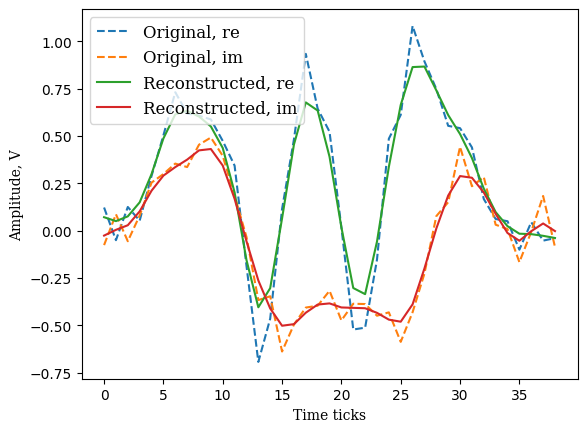

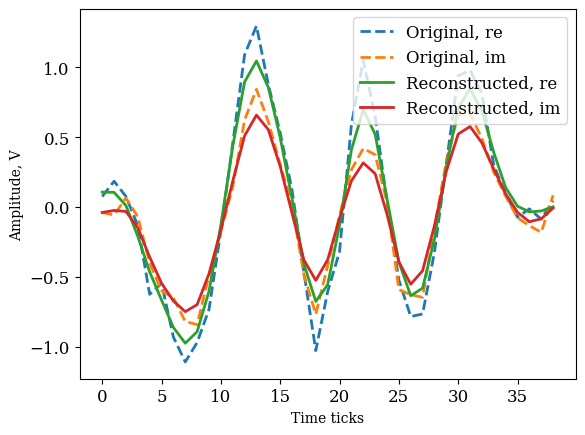

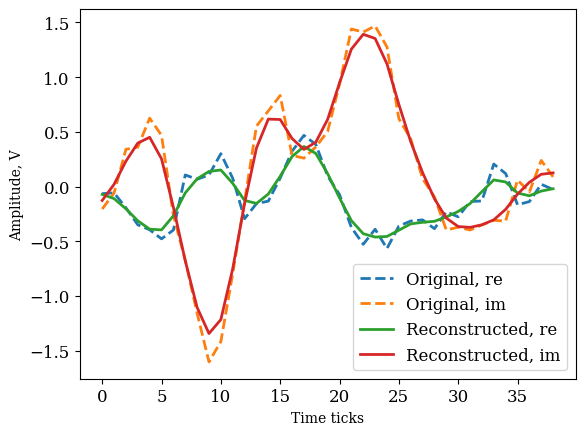

In [ ]:
# Filter Gaussian noise by the median averaging, small window ??? CHECK! how to filter IQdata
Xdenoise = np.empty(Xsrc.shape, dtype=complex)

# window_size = 3 # Filtering parameters
# kernel = np.ones(window_size, dtype=complex) / window_size  # Create averaging kernel

for x, i in zip(Xsrc, range(len(Xsrc))):
  Xdenoise[i] = gaussian_filter1d(x, sigma=1)
  # Xdenoise[i] = signal.convolve(x, signal.gauss_spline(51, 7), mode='same') / sum(signal.gauss_spline(51, 7)) # Apply Gaussian filter
  #Xdenoise[i].real = np.convolve(x.real, kernel, mode='same')  # Apply convolution
  #Xdenoise[i].imag = np.convolve(x.imag, kernel, mode='same')  # Apply convolution

#plt.plot(z.imag)
#plt.show()

plt_rand(Xsrc, Xdenoise, 3)

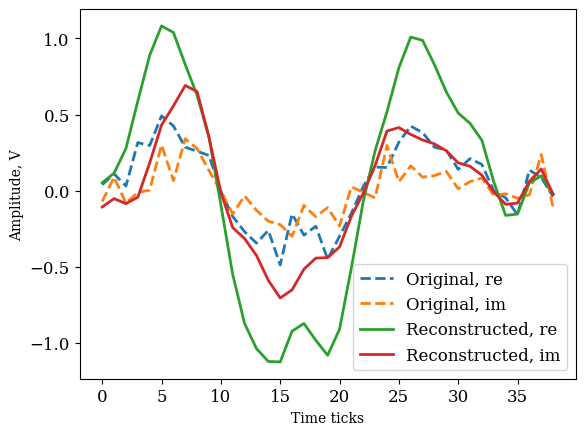

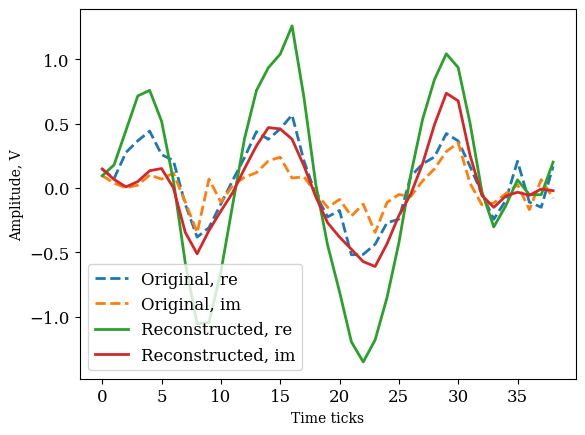

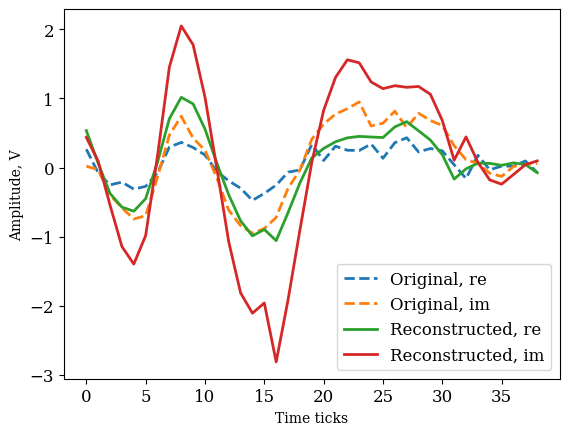

In [ ]:
# Amplify small chages in signal using DWT
Xdwt = np.empty(Xsrc.shape, dtype=complex)

for x, i in zip(Xdenoise, range(len(Xsrc))):
  # Apply Wavelet Transform using Haar wavelet
  coeffs = pywt.wavedec(x, 'haar', level=4)  # Decomposition into 4 levels
  # Amplify the last (smallest) detail coefficients (high-frequency changes)
  coeffs[1:] = [c * 3 for c in coeffs[1:]]  # Amplifyn level 1-4)
  # Reconstruct the time series with the amplified coefficients
  amplified_time_series_wavelet = pywt.waverec(coeffs, 'haar')
  Xdwt[i] = amplified_time_series_wavelet[:-1]

plt_rand(Xsrc, Xdwt, 3)

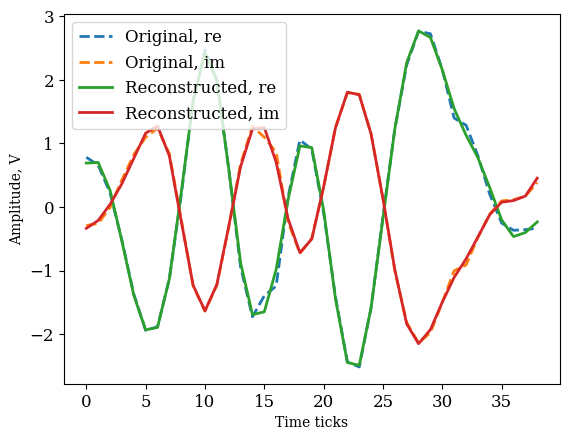

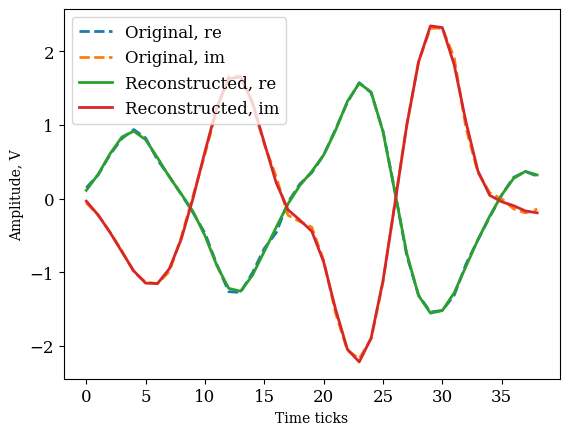

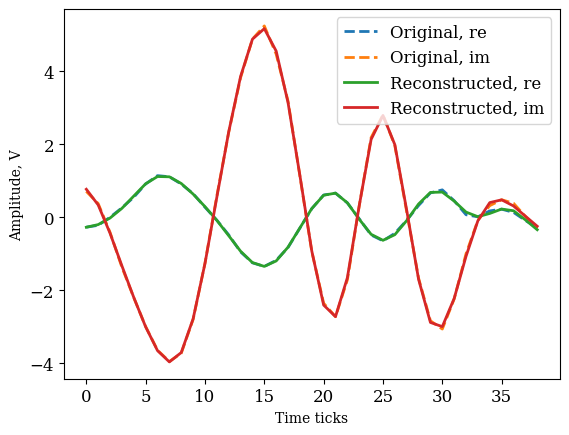

In [ ]:
# Extract features from SSA
ncols = 10
ncomps = 5
Xssa = np.empty(Xsrc.shape, dtype=complex)
Xhr = np.empty(Xsrc.shape, dtype=complex)
Xlambd = np.empty((len(Xsrc), ncomps), dtype=complex)
Xrotat = np.empty((len(Xsrc), ncomps**2), dtype=complex)

for x, i in zip(Xdwt, range(len(Xsrc))):
  # Extract singular values and vectors from SVD of the Hankel matrix
  Xssa[i], _, _, Xlambd[i], rotat  = ssa(x, ncols, ncomps)
  rotat = rotat[:,:ncomps]
  Xrotat[i]  = rotat.reshape(-1)

plt_rand(Xdwt, Xssa, 3)

In [ ]:
# Feature egineering
Xenergy = np.sum(np.abs(Xsrc)**2, axis=1)
# Feature collecting
Xea = np.concatenate((Xenergy.reshape(-1, 1), Xlambd.real, Xlambd.imag, Xrotat.real, Xrotat.imag), axis=1)

In [ ]:
# Metric feature engineering
iq_idx_centroids = np.load('iq_idx_centroids.npy')
Xmetric = np.empty((len(Xsrc), len(iq_idx_centroids)))
for i in range(len(Xsrc)):
  d = np.empty(len(iq_idx_centroids))
  for j, i_idx in zip(range(len(iq_idx_centroids)), iq_idx_centroids):
    obj = Xsrc[i]
    obj = obj / np.sqrt(np.sum(np.abs(obj)**2))
    # print(i_idx.astype(int))
    centroid = iqdata[i_idx.astype(int)]
    centroid = centroid / np.sqrt(np.sum(np.abs(centroid)**2))
    d[j] = np.linalg.norm(obj - centroid)
  Xmetric[i] = d

In [ ]:
Xea = np.concatenate((Xenergy.reshape(-1, 1), Xlambd.real, Xlambd.imag, Xmetric), axis=1)

Accuracy (logistic regression): 0.44
Classification Report:
               precision    recall  f1-score   support

         0.0       0.44      0.33      0.38       257
         1.0       0.44      0.56      0.49       243

    accuracy                           0.44       500
   macro avg       0.44      0.44      0.43       500
weighted avg       0.44      0.44      0.43       500



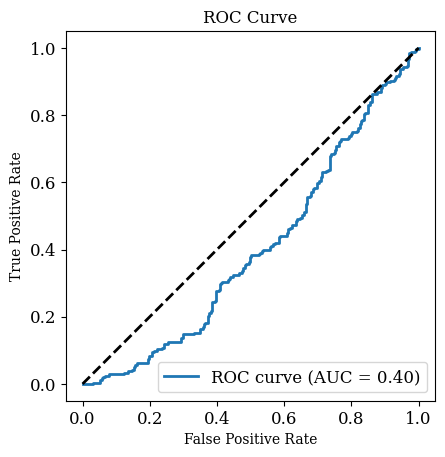

AUC: 0.4482073945973643
Accuracy (kNN): 0.452
Classification Report:
               precision    recall  f1-score   support

         0.0       0.47      0.58      0.52       257
         1.0       0.42      0.31      0.36       243

    accuracy                           0.45       500
   macro avg       0.44      0.45      0.44       500
weighted avg       0.45      0.45      0.44       500



In [ ]:
# Classify the data set with logistic regression and kNN

X = Xea
y = Ysrc

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
#------------------------------------------------------------------
# Logistic regression
model = LogisticRegression() # Create the logistic regression model
model.fit(X_train, y_train) # Train the model
y_pred = model.predict(X_test) # Make predictions
y_pred_proba = model.predict_proba(X_test)[:, 1] # Get probabilities for ROC curve

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy (logistic regression):", accuracy)
print("Classification Report:\n", report)

# Calculate and plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.show()
#------------------------------------------------------------------
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Create a KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # The number of neighbors, k
knn.fit(X_train, y_train) # Fit the model
y_pred = knn.predict(X_test) # Make predictions
auc = roc_auc_score(y_test, y_pred)
# Calculate AUC score and accuracy
print("AUC:", auc)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy (kNN):", accuracy)
print("Classification Report:\n", report)